# EDA for IPL Dataset
Arham Aneeq / 240005009


## Tools & Libraries Used

In [1]:
# IMPORTS
# Data Manipulation
import pandas as pd

# Visualisation

import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle

# Statistics

import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp

# Classification & Regression
import sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import networkx as nx
from sklearn.decomposition import PCA

## Cleaning

### Initial Dataframe

In [2]:
df = pd.read_csv("final_dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052 entries, 0 to 1051
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1052 non-null   int64  
 1   Country      1052 non-null   object 
 2   Player       1052 non-null   object 
 3   Team         1052 non-null   object 
 4   Base price   1052 non-null   float64
 5   Winning bid  1052 non-null   object 
 6   Year         1052 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 57.7+ KB


In [4]:
df.nunique()

Unnamed: 0     1052
Country          29
Player          593
Team             17
Base price       15
Winning bid     128
Year             11
dtype: int64

### Cleaning Steps

In [5]:
# Drop Empty Columns
df = df.drop(df.columns[df.columns.str.contains('Unnamed', case=False)], axis=1)

In [6]:
# Strip nonumeric characters form the 'Winning bid' column, and recast data type to float
df['Winning bid'] = df['Winning bid'].str.extract(r'(\d+\.?\d*)').astype(float)

In [7]:
# Strip Extra Whitespaces from 
df['Country'] = df['Country'].str.extract(r'^\s*(.*?)\s*$')

In [8]:
# Define a New Change (Delta) Column
df['Change'] = df['Winning bid'] - df['Base price']
# Remove Elements with Negative Change
df = df[df['Change'] >= 0]

In [9]:
# Fix typos in the 'Team' column
for row in df.index:
    if df.loc[row, 'Team'] == 'Delhi Dardevils':
        df.loc[row, 'Team'] = 'Delhi Daredevils'
    if df.loc[row, 'Team'] == 'Delhi Daredevils':
        df.loc[row, 'Team'] = 'Delhi Capitals'
    if df.loc[row, 'Team'] == 'Rising Pune Supergiants':
        df.loc[row, 'Team'] = 'Rising Pune Supergiant'
    if df.loc[row, 'Team'] == 'Rising Pune Supergiant':
        df.loc[row, 'Team'] = 'Lucknow Super Giants'
    if df.loc[row, 'Team'] == 'Kings XI Punjab':
        df.loc[row, 'Team'] = 'Punjab Kings'

In [10]:
# Club West Indies Teams
for row in df.index:
    if df.loc[row, 'Country'] in {"Namibia", 'Trinidad and Tobago', 'Jamaica', 'Barbados', 'Guyana'}:
        df.loc[row, 'Country'] = 'West Indies'

In [11]:
# Drop Duplicate Columns
df = df.drop_duplicates()

### Cleaned Dataframe

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1042 entries, 0 to 1048
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      1042 non-null   object 
 1   Player       1042 non-null   object 
 2   Team         1042 non-null   object 
 3   Base price   1042 non-null   float64
 4   Winning bid  1042 non-null   float64
 5   Year         1042 non-null   int64  
 6   Change       1042 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 65.1+ KB


In [13]:
df.nunique()

Country         15
Player         591
Team            12
Base price      15
Winning bid    121
Year            11
Change         139
dtype: int64

### Derived Tables

In [14]:
player_df = df.groupby('Player').agg(
    Num_of_Teams=('Team', 'nunique'),
    Base_Price_High=('Base price', 'max'),
    Base_Price_Low=('Base price', 'min'),
    Winning_Bid_High = ('Winning bid', 'max'),
    Winning_Bid_Mean = ('Winning bid', 'mean'),
    Winning_Bid_Low = ('Winning bid', 'max'),
    Largest_Delta = ('Change', 'max'),
    Smallest_Delta = ('Change', 'min'),
    Mean_Delta = ('Change', 'mean'),
    Country = ('Country', 'first'),
    Year_Range = ('Year', lambda year: year.max() - year.min()),
    Avg_Trade_Gap = ('Year', lambda year: np.mean(gaps) if len((gaps := np.diff(sorted(year.unique())))) > 0 else year.max() - year.min())
).reset_index()
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Player            591 non-null    object 
 1   Num_of_Teams      591 non-null    int64  
 2   Base_Price_High   591 non-null    float64
 3   Base_Price_Low    591 non-null    float64
 4   Winning_Bid_High  591 non-null    float64
 5   Winning_Bid_Mean  591 non-null    float64
 6   Winning_Bid_Low   591 non-null    float64
 7   Largest_Delta     591 non-null    float64
 8   Smallest_Delta    591 non-null    float64
 9   Mean_Delta        591 non-null    float64
 10  Country           591 non-null    object 
 11  Year_Range        591 non-null    int64  
 12  Avg_Trade_Gap     591 non-null    float64
dtypes: float64(9), int64(2), object(2)
memory usage: 60.2+ KB


In [15]:
team_df = df.groupby('Team').agg(
    Num_of_Players = ('Player', 'nunique'),
    Winning_Bid_High = ('Winning bid', 'max'),
    Winning_Bid_Mean = ('Winning bid', 'mean'),
    Winning_Bid_Low = ('Winning bid', 'min'),
    Largest_Delta = ('Change', 'max'),
    Mean_Delta = ('Change', 'mean'),
).reset_index()
team_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Team              12 non-null     object 
 1   Num_of_Players    12 non-null     int64  
 2   Winning_Bid_High  12 non-null     float64
 3   Winning_Bid_Mean  12 non-null     float64
 4   Winning_Bid_Low   12 non-null     float64
 5   Largest_Delta     12 non-null     float64
 6   Mean_Delta        12 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 804.0+ bytes


In [16]:
yearly_df = df.groupby("Year").agg(
    Num_of_Auctioned_Players = ('Player', 'nunique'),
    Num_of_Bidding_Teams = ('Team', 'nunique'),
    Winning_High = ('Winning bid', 'max'),
    Winning_Mean = ('Winning bid', 'mean'),
    Winning_Low = ('Winning bid', 'min'),
    Base_High = ('Base price', 'max'),
    Base_Low = ('Base price', 'min'),
    Delta_High = ('Change', 'max'),
    Delta_Mean = ('Change', 'mean'),
    Total_Traded_Volume = ('Winning bid', 'sum'),
).reset_index()

yearly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      11 non-null     int64  
 1   Num_of_Auctioned_Players  11 non-null     int64  
 2   Num_of_Bidding_Teams      11 non-null     int64  
 3   Winning_High              11 non-null     float64
 4   Winning_Mean              11 non-null     float64
 5   Winning_Low               11 non-null     float64
 6   Base_High                 11 non-null     float64
 7   Base_Low                  11 non-null     float64
 8   Delta_High                11 non-null     float64
 9   Delta_Mean                11 non-null     float64
 10  Total_Traded_Volume       11 non-null     float64
dtypes: float64(8), int64(3)
memory usage: 1.1 KB


## Analysis

### Univariate Analysis

#### Table Description

In [ ]:
df.describe()

,Base price,Winning bid,Year,Change
count,1042.000000,1042.000000,1042.000000,1042.000000
mean,64.323608,200.825192,2018.288868,136.501583
std,62.611636,269.391757,3.140338,238.500161
min,10.000000,10.000000,2013.000000,0.000000
25%,20.000000,20.000000,2016.000000,0.000000
50%,30.000000,80.000000,2018.000000,5.000000
75%,100.000000,274.500000,2022.000000,180.000000
max,244.000000,1625.000000,2023.000000,1550.000000


In [18]:
team_df.describe()

,Num_of_Players,Winning_Bid_High,Winning_Bid_Mean,Winning_Bid_Low,Largest_Delta,Mean_Delta
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,78.500000,1249.354167,209.521156,30.333333,1121.812500,143.212204
std,39.725192,430.243595,69.128721,67.348933,385.053555,56.672999
min,4.000000,400.000000,82.333333,10.000000,390.000000,42.333333
25%,47.000000,1075.000000,187.295459,10.000000,965.000000,118.929996
50%,99.000000,1425.000000,199.116751,10.000000,1250.000000,138.226284
75%,109.500000,1531.250000,226.169920,10.000000,1381.250000,156.503009
max,119.000000,1625.000000,381.250000,244.000000,1550.000000,282.125000


In [19]:
player_df.describe()

,Num_of_Teams,Base_Price_High,Base_Price_Low,Winning_Bid_High,Winning_Bid_Mean,Winning_Bid_Low,Largest_Delta,Smallest_Delta,Mean_Delta,Year_Range,Avg_Trade_Gap
count,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000
mean,1.593909,67.683926,45.798985,234.128257,160.637386,234.128257,171.559391,50.260914,104.322164,1.883249,1.144802
std,0.913680,66.707578,50.420205,313.411716,197.935981,313.411716,279.536278,129.032640,170.237917,2.706848,1.614266
min,1.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,20.000000,20.000000,20.000000,20.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,30.000000,20.000000,90.000000,75.000000,90.000000,20.000000,0.000000,12.500000,0.000000,0.000000
75%,2.000000,100.000000,50.000000,320.000000,234.906250,320.000000,250.000000,25.000000,151.250000,4.000000,2.000000
max,6.000000,244.000000,244.000000,1625.000000,1350.000000,1625.000000,1550.000000,1050.000000,1150.000000,10.000000,8.000000


In [20]:
yearly_df.describe()

,Year,Num_of_Auctioned_Players,Num_of_Bidding_Teams,Winning_High,Winning_Mean,Winning_Low,Base_High,Base_Low,Delta_High,Delta_Mean,Total_Traded_Volume
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,2018.000000,94.636364,8.454545,1193.181818,188.432928,15.654545,204.000000,15.654545,1048.000000,127.793758,19023.622727
std,3.316625,54.494537,0.820200,374.708371,55.603896,5.031176,13.266499,5.031176,354.661811,45.870231,15842.932294
min,2013.000000,37.000000,8.000000,610.000000,115.066667,10.000000,200.000000,10.000000,488.000000,61.333333,7249.850000
25%,2015.500000,61.000000,8.000000,870.000000,143.361541,10.000000,200.000000,10.000000,772.500000,90.729665,8922.500000
50%,2018.000000,66.000000,8.000000,1250.000000,178.000000,20.000000,200.000000,20.000000,1050.000000,123.583333,13970.000000
75%,2020.500000,122.500000,8.500000,1537.500000,240.601302,20.000000,200.000000,20.000000,1362.500000,167.031399,19220.000000
max,2023.000000,204.000000,10.000000,1625.000000,270.808824,20.000000,244.000000,20.000000,1550.000000,196.495098,55245.000000


#### Graphs

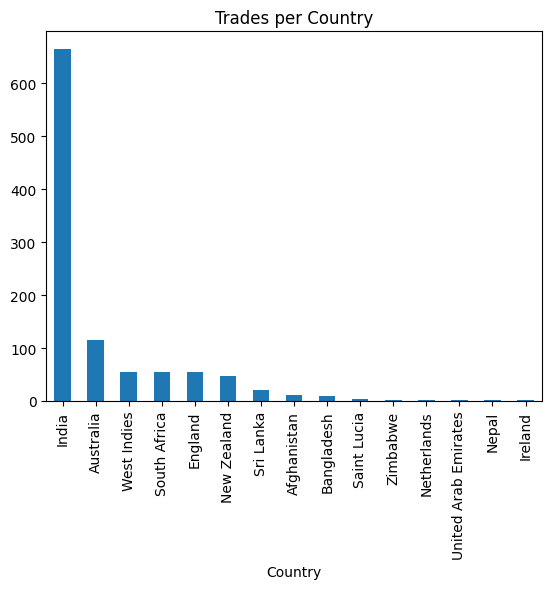

In [21]:
df['Country'].value_counts().plot(kind="bar")
plt.title("Trades per Country")
plt.show()

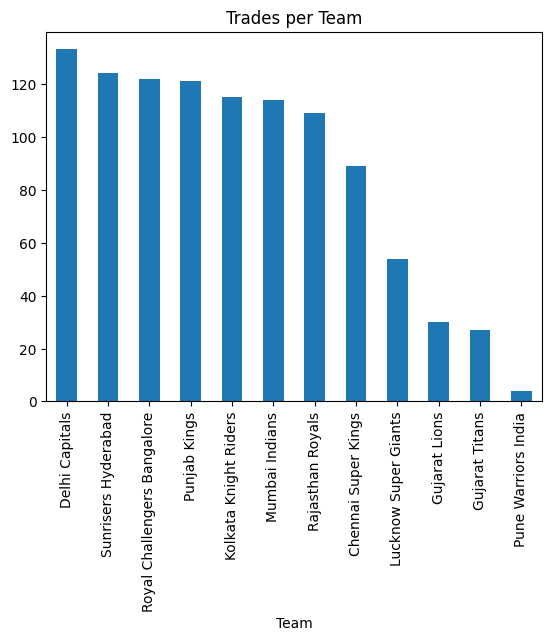

In [22]:
df['Team'].value_counts().plot(kind="bar")
plt.title("Trades per Team")
plt.show()

### Multivariate Analysis

#### Correlation Analysis

In [23]:
corr_player = player_df.select_dtypes(include="number").corr()
corr_team = team_df.select_dtypes(include="number").corr()
corr_yearly = yearly_df.select_dtypes(include="number").corr()

Text(0.5, 1.0, 'Playerwise Correlation')

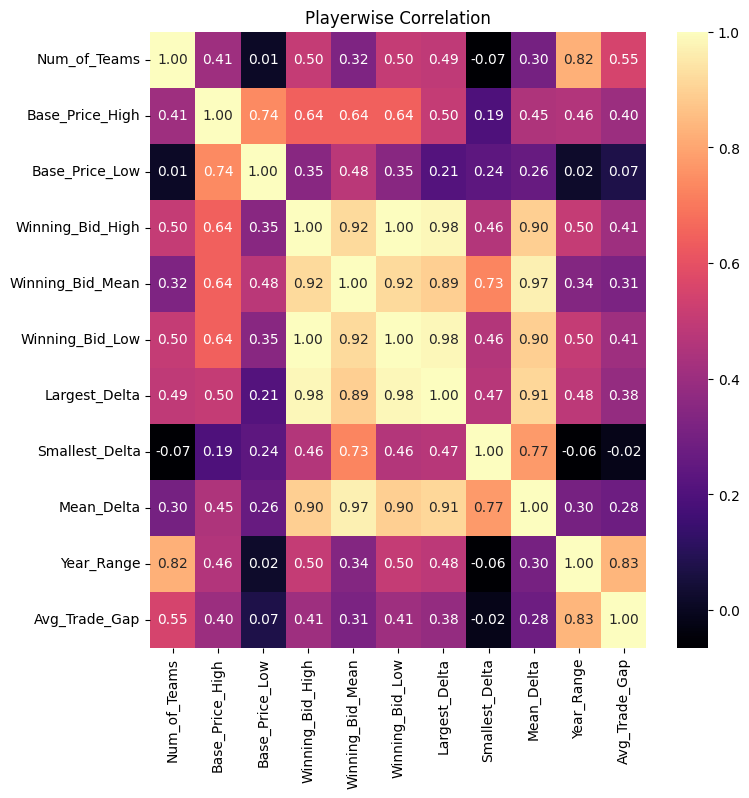

In [24]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_player, annot=True, cmap='magma', fmt='.2f')
plt.title('Playerwise Correlation')

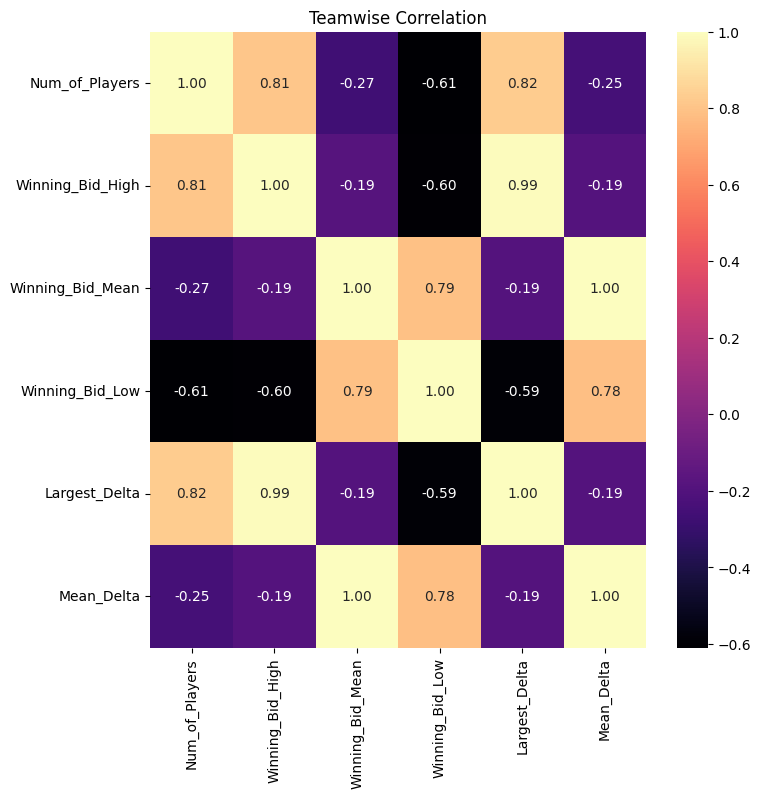

In [25]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_team, annot=True, cmap='magma', fmt='.2f')
plt.title('Teamwise Correlation')

plt.show()

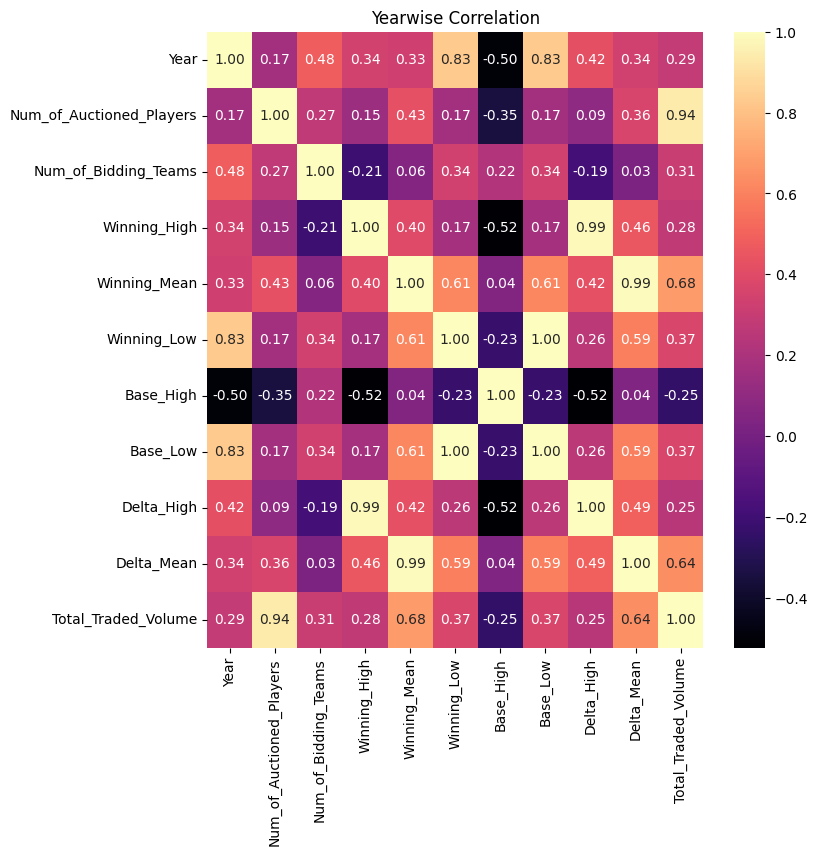

In [26]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_yearly, annot=True, cmap='magma', fmt='.2f')
plt.title('Yearwise Correlation')

plt.show()

#### Dunn Tests

##### Heatmaps

Text(0.5, 1.0, 'Dunn Test by Country Bonferroni adjusted p-values')

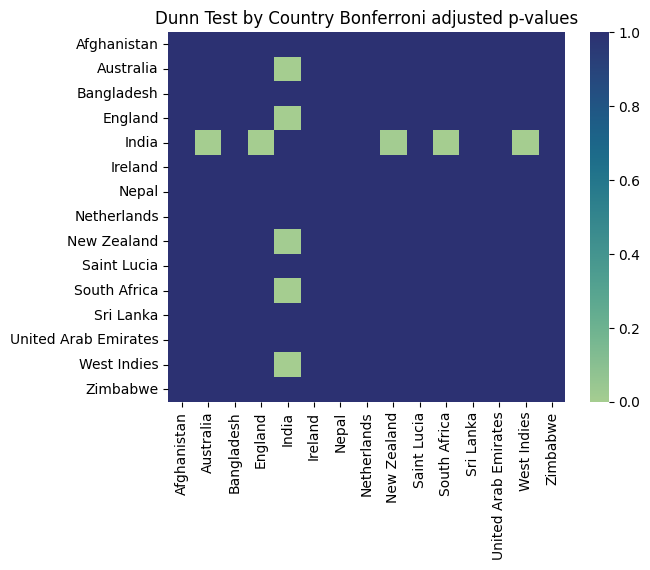

In [27]:
sns.heatmap(data=sp.posthoc_dunn(df, val_col='Winning bid', group_col='Country', p_adjust='bonferroni'), cmap='crest')
plt.title("Dunn Test by Country Bonferroni adjusted p-values")

Text(0.5, 1.0, 'Dunn Test by Team Bonferroni adjusted p-values')

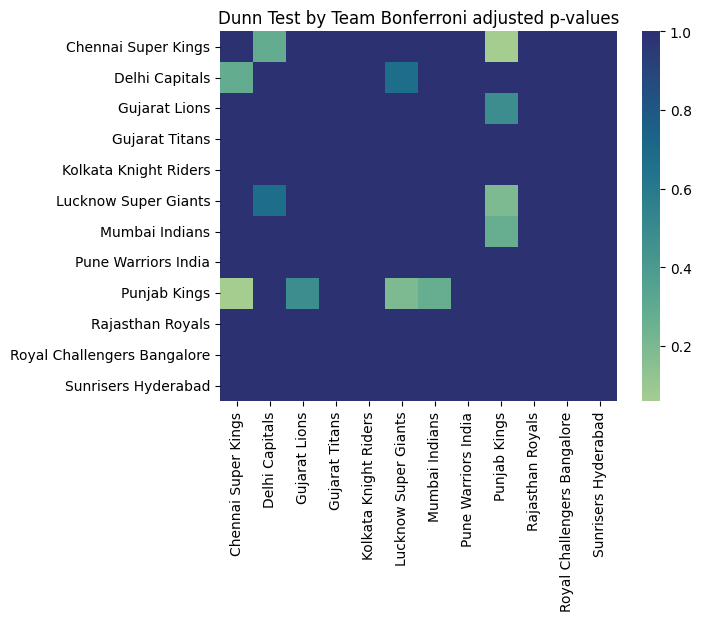

In [28]:
sns.heatmap(data=sp.posthoc_dunn(df, val_col='Change', group_col='Team', p_adjust='bonferroni'), cmap='crest')
plt.title("Dunn Test by Team Bonferroni adjusted p-values")

##### Boxplots

C:\Users\arham\AppData\Local\Temp\ipykernel_20888\528127490.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Country', y='Winning bid', palette="coolwarm")
C:\Users\arham\AppData\Local\Temp\ipykernel_20888\528127490.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Country', y='Change', palette="coolwarm")
C:\Users\arham\AppData\Local\Temp\ipykernel_20888\528127490.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Team", y="Winning bid", palette="flare")
C:\Users\arham\AppData\Local\Temp\ipykernel_2

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Royal Challengers Bangalore'),
  Text(1, 0, 'Delhi Capitals'),
  Text(2, 0, 'Pune Warriors India'),
  Text(3, 0, 'Mumbai Indians'),
  Text(4, 0, 'Chennai Super Kings'),
  Text(5, 0, 'Sunrisers Hyderabad'),
  Text(6, 0, 'Rajasthan Royals'),
  Text(7, 0, 'Punjab Kings'),
  Text(8, 0, 'Kolkata Knight Riders'),
  Text(9, 0, 'Lucknow Super Giants'),
  Text(10, 0, 'Gujarat Lions'),
  Text(11, 0, 'Gujarat Titans')])

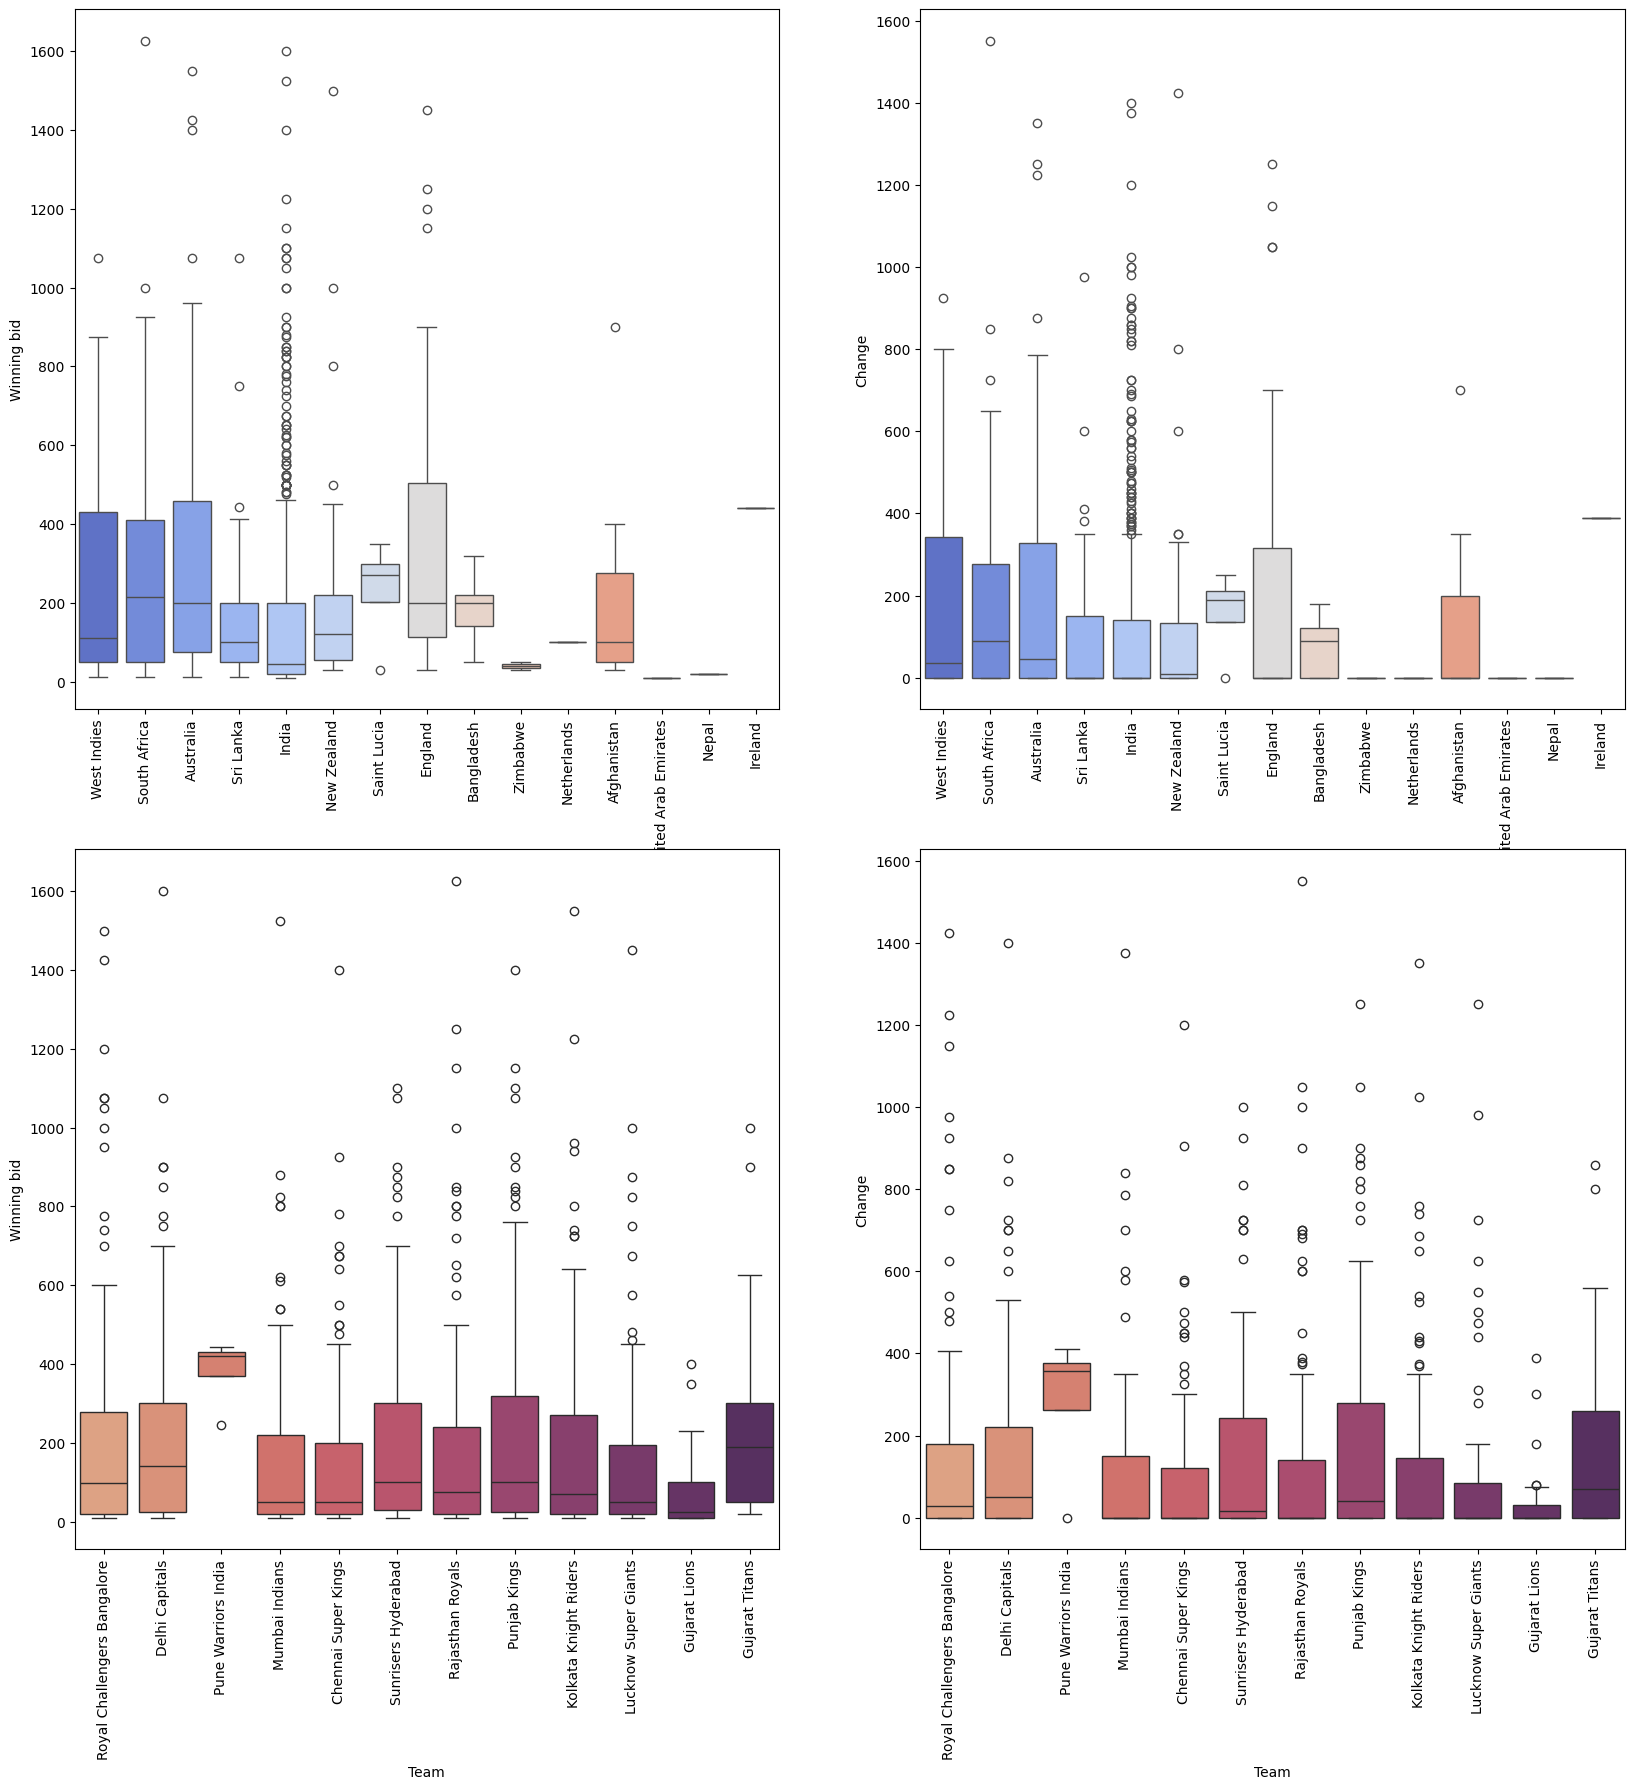

In [29]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='Country', y='Winning bid', palette="coolwarm")
plt.xticks(rotation=90)
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='Country', y='Change', palette="coolwarm")
plt.xticks(rotation=90)
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x="Team", y="Winning bid", palette="flare")
plt.xticks(rotation=90)
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x="Team", y="Change", palette="flare")
plt.xticks(rotation = 90)

#### Yearwise Statistics

C:\Users\arham\AppData\Local\Temp\ipykernel_20888\1936032474.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Year", y="Winning bid", data=df, palette="flare")
C:\Users\arham\AppData\Local\Temp\ipykernel_20888\1936032474.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Year", y="Base price", data=df, palette="magma")
C:\Users\arham\AppData\Local\Temp\ipykernel_20888\1936032474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Year", y="Change", data=df, palette="coolwarm")
C:\Users\arham\AppData\Local\Temp\ipykernel_20888\19

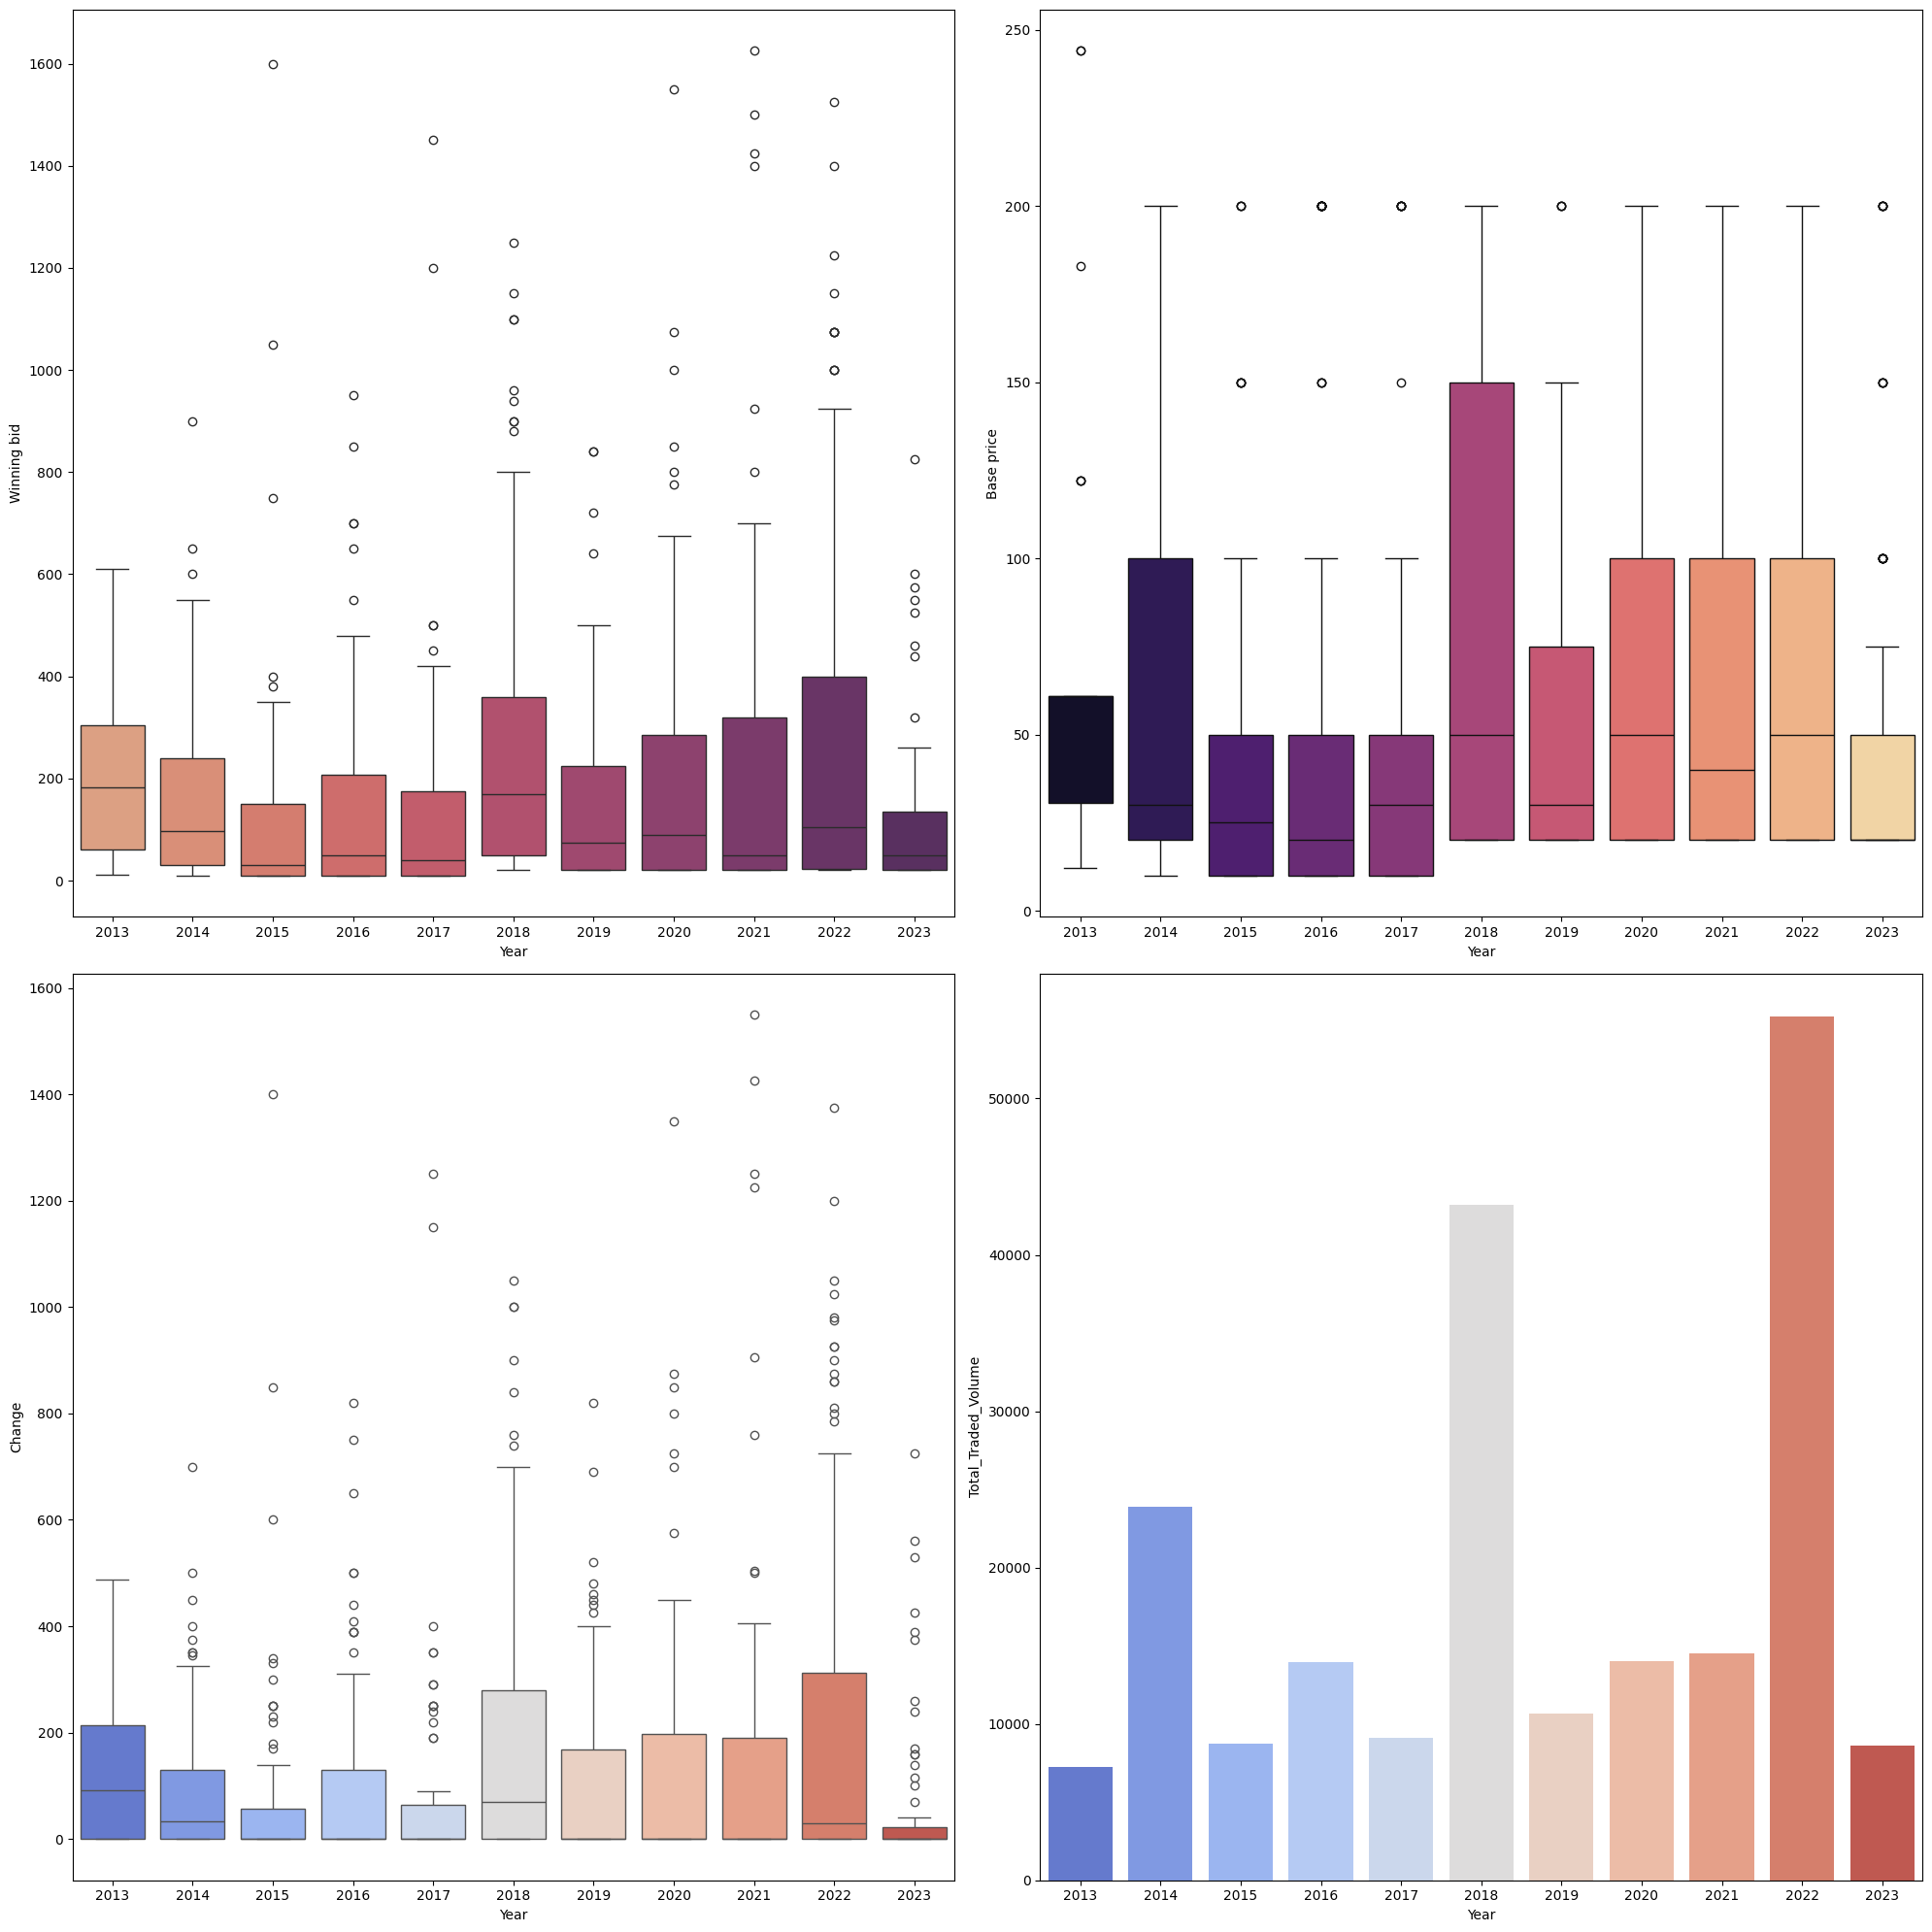

In [30]:
plt.figure(figsize=(20,20))
plt.subplot(2, 2, 1)
sns.boxplot(x="Year", y="Winning bid", data=df, palette="flare")
plt.tight_layout()
plt.subplot(2,2,2)
sns.boxplot(x="Year", y="Base price", data=df, palette="magma")
plt.tight_layout()
plt.subplot(2,2,3)
sns.boxplot(x="Year", y="Change", data=df, palette="coolwarm")
plt.tight_layout()
plt.subplot(2, 2, 4)
sns.barplot(x="Year", y="Total_Traded_Volume", data=yearly_df, palette="coolwarm")
plt.tight_layout()

plt.show()

## Machine Learning

### Clustering

#### PCA + K-Means Clustering of Players

In [31]:
# PCA
pca_player_df = pd.DataFrame(
    PCA(n_components=2).fit_transform(StandardScaler().fit_transform(player_df[[
        'Base_Price_High',
        'Winning_Bid_High',
        'Winning_Bid_Mean',
        'Winning_Bid_Low',
        'Largest_Delta',
        'Mean_Delta',
        'Num_of_Teams',
        'Year_Range',
        'Avg_Trade_Gap'
    ]])),

    columns=['PC1', 'PC2']
)

pca_player_df['Player'] = player_df['Player']

In [32]:
# K-Means
pca_player_df['Cluster'] = KMeans(
    n_clusters=4,
    n_init=10,
    random_state=42
    ).fit_predict(
        PCA(n_components=2).fit_transform(StandardScaler().fit_transform(player_df[[
            'Base_Price_High',
            'Winning_Bid_High',
            'Winning_Bid_Mean',
            'Winning_Bid_Low',
            'Largest_Delta',
            'Mean_Delta',
            'Num_of_Teams',
            'Year_Range',
            'Avg_Trade_Gap'
        ]]))
    )

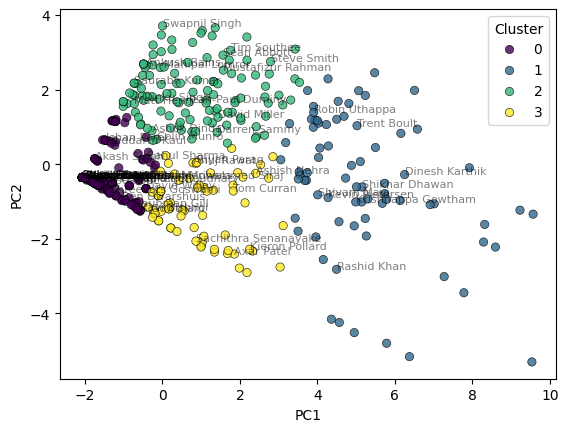

In [33]:
# PLOT
sns.scatterplot(
    x = pca_player_df['PC1'],
    y = pca_player_df['PC2'],
    hue = pca_player_df['Cluster'],
    palette = 'viridis', alpha = 0.8, edgecolor = 'k'
)

for i, player in enumerate(pca_player_df['Player']):
    if np.random.rand() < 0.1:
        plt.annotate(player, (pca_player_df['PC1'][i], pca_player_df['PC2'][i]), fontsize = 8, alpha=0.5)

In [39]:
# Metrics
print("PCA + KMC Silhouette Score: ")
print((lambda X: (sklearn.metrics.silhouette_score(X, KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
).fit_predict(X))))(
    PCA(n_components=2).fit_transform(StandardScaler().fit_transform(player_df[[
        'Base_Price_High',
        'Winning_Bid_High',
        'Winning_Bid_Mean',
        'Winning_Bid_Low',
        'Largest_Delta',
        'Mean_Delta',
        'Num_of_Teams',
        'Year_Range',
        'Avg_Trade_Gap'
    ]]))
))

PCA + KMC Silhouette Score: 
0.5774974515069257


#### Dendogram for Teams

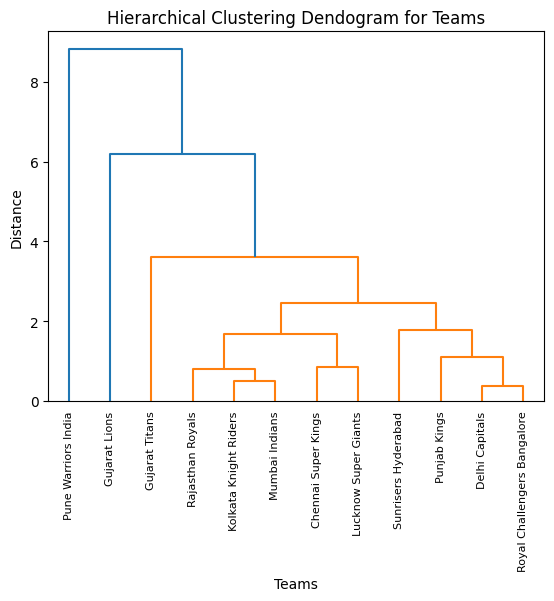

In [35]:
dendrogram(
    linkage(StandardScaler().fit_transform(
        team_df[[
            'Num_of_Players',
            'Winning_Bid_High',
            'Winning_Bid_Mean',
            'Winning_Bid_Low',
            'Largest_Delta',
            'Mean_Delta'
        ]]
    ), 
    method="ward"),

    labels=team_df['Team'].values,
    leaf_rotation=90,
    leaf_font_size=8
)

plt.title("Hierarchical Clustering Dendogram for Teams")
plt.xlabel("Teams")
plt.ylabel("Distance")

plt.show()

### Regression

#### Linear Regression

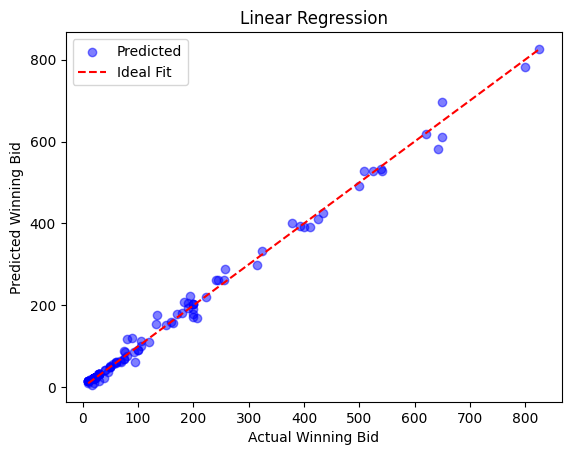

In [37]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    player_df[[
        'Base_Price_High',
        'Num_of_Teams',
        'Largest_Delta',
        'Mean_Delta',
        'Year_Range',
        'Avg_Trade_Gap'
    ]],

    player_df[[
        'Winning_Bid_Mean'
    ]],

    test_size=0.2, random_state=42
)

model = sklearn.linear_model.LinearRegression().fit(X_train, Y_train)

Y_pred = model.predict(X_test)

plt.scatter(Y_test, Y_pred, alpha=0.5, color='blue', label="Predicted")
plt.plot(
    [Y_test.min(), Y_test.max()],
    [Y_test.min(), Y_test.max()],
    color = 'red', linestyle = '--', label = 'Ideal Fit'
)

plt.xlabel("Actual Winning Bid")
plt.ylabel("Predicted Winning Bid")
plt.title("Linear Regression")
plt.legend()

plt.show()

In [38]:
print("Linear R² Score: ")
print(sklearn.metrics.r2_score(Y_test, Y_pred))

print("Linear RMSE: ")
print(sklearn.metrics.root_mean_squared_error(Y_test, Y_pred))

Linear R² Score: 
0.9940576111089753
Linear RMSE: 
14.270059378657145
